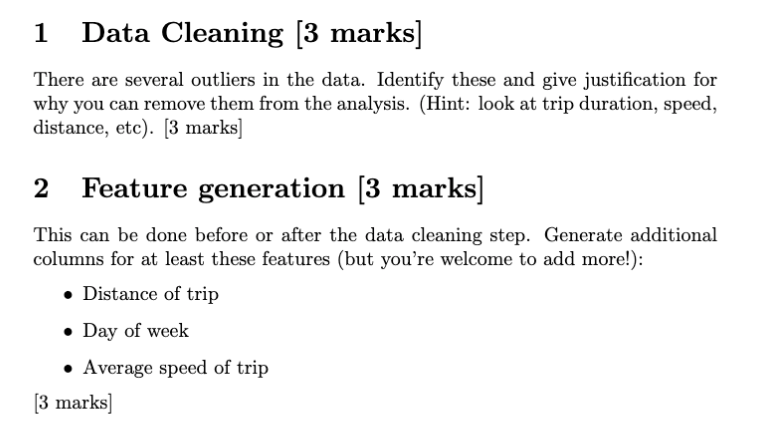

# Libraries

In [60]:
#Pandas
import pandas as pd
#Numpy
import numpy as np
#Folium
import folium
#Fiona
import fiona
#Shapely
import shapely
#Geopandas
import geopandas as gpd
#Sklearn cluster dbscan
from sklearn.cluster import DBSCAN
#Matplotlib
import matplotlib.pyplot as plt
#Seaborn
import seaborn as sns

# Loading the data

In [61]:
# Load dataset
df = pd.read_csv('nyc_taxis/nyc_taxis.csv')

In [62]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [63]:
# Print the number of missing values in each column
print(df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


# Type Conversion

In [64]:
# Convert datetime columns to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Feature: Trip Duration

In [65]:
# Calculate trip duration in minutes
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

In [66]:
# Remove trips with zero or negative duration
df = df[df['trip_duration'] > 0]

# Distance between pickup and dropoff locations

In [67]:
# Calculate the Haversine distance between pickup and dropoff locations
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

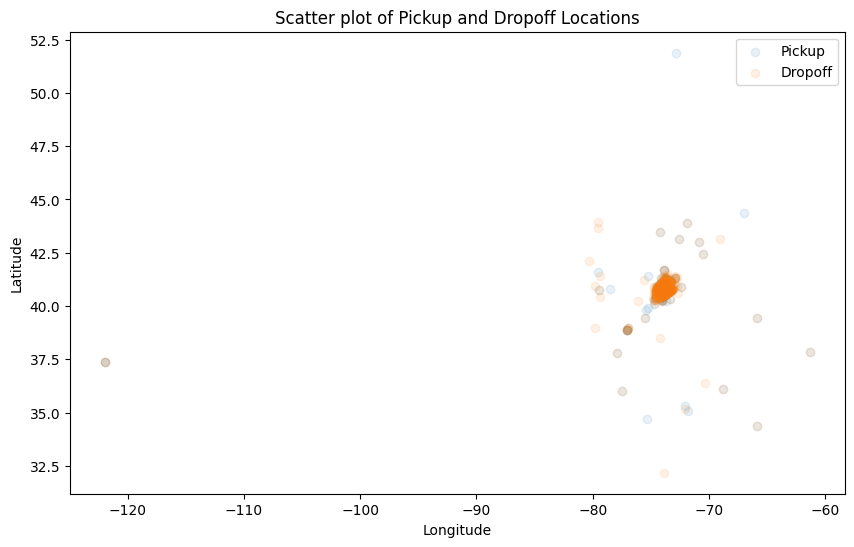

In [68]:
# Scatter plot of pickup and dropoff locations
plt.figure(figsize=(10, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.1, label='Pickup')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], alpha=0.1, label='Dropoff')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of Pickup and Dropoff Locations')
plt.legend()
plt.show()

In [69]:
# Apply the haversine function to each row
df['trip_distance'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [70]:
# Remove trips with zero distance
df = df[df['trip_distance'] > 0]

# Feature: Average Speed

In [71]:
# Calculate average speed (km/h)
df['avg_speed'] = (df['trip_distance'] / (df['trip_duration'] / 60))

# Trip Duration

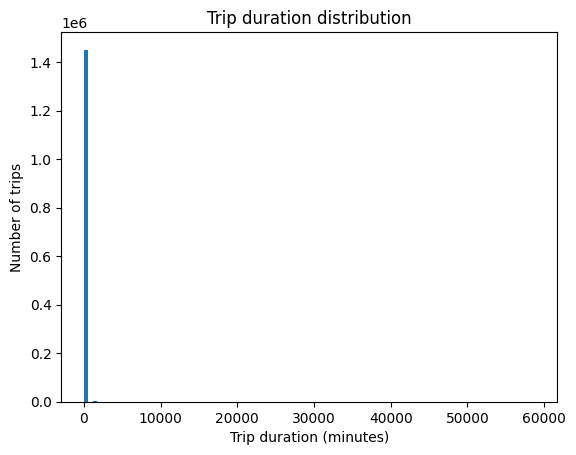

In [72]:
# Plot the trip duration, so we can see the distribution, also have a threshold of 1000 minutes
df['trip_duration'].plot(kind='hist', bins=100)
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.title('Trip duration distribution')
plt.show()

The histogram shows the distribution of trip durations. It is heavily right-skewed, meaning most of the trips are short, with the majority under 50 minutes, and a long tail representing trips with longer durations. Given this, we can make decisions on how to clean the data:

Justification for Data Cleaning
Trip Duration:

The plot shows that the majority of trips last under 50 minutes. Extremely long trips could be considered outliers because they deviate significantly from the bulk of the data.
Based on this distribution, we can remove trips with a duration exceeding 120 minutes (2 hours) as these are likely outliers and not representative of typical NYC taxi rides.
We should also remove trips with extremely short durations, such as trips lasting less than 1 minute, as they might represent errors in the data or cases where the trip was immediately canceled.
Distance:

Although not directly shown in this plot, we can assume that trips with a very small or zero distance (e.g., under 100 meters) are also erroneous and should be removed.
Speed:

After calculating the average speed of each trip, trips with unrealistic speeds, such as over 100 km/h or below 1 km/h, should be filtered out, as such speeds are unlikely for urban trips in NYC.

In [73]:
# Identify outliers based on trip duration, distance, and average speed
df = df[(df['trip_duration'] < 120) & (df['trip_duration'] > 1)]

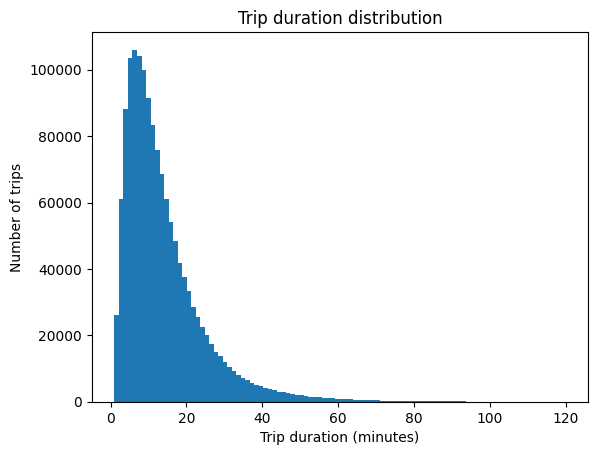

In [74]:
# Plot the new trip duration
df['trip_duration'].plot(kind='hist', bins=100)
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.title('Trip duration distribution')
plt.show()

# Trip Distance

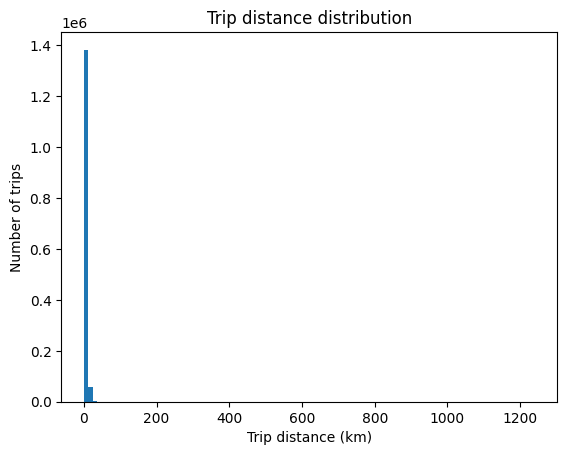

In [75]:
# Plot the trip distance, so we can see the distribution, also have a threshold
df['trip_distance'].plot(kind='hist', bins=100)
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')
plt.title('Trip distance distribution')
plt.show()

The histogram represents the trip distance distribution, which shows that the majority of trips are short distances (most are under 20 km), and the distribution is again right-skewed with a long tail. Let’s combine the insights from both the trip duration and trip distance histograms to refine the data cleaning strategy:

Justification for Cleaning with Trip Distance:
Trip Distance:

Similar to the trip duration distribution, this histogram indicates that most trips fall under 20 km, with a small percentage of trips extending beyond this.
We see an especially sharp spike at near-zero distances. These near-zero trips likely represent errors, or cases where the trip was canceled or incomplete. Removing trips with extremely short distances (e.g., under 100 meters) is reasonable, as they are likely erroneous.
Trips with extreme distances (e.g., beyond 25 km) are highly unlikely for typical NYC taxi trips and could be considered outliers. Based on this, we can filter trips that exceed a distance of 25 km.
Combining with Duration:

Trips with short distances but long durations might indicate potential outliers. For example, if a trip covers 1 km but takes 2 hours, that would likely be an error.
The converse also holds: a trip covering a long distance in a very short time (e.g., 100 km in 5 minutes) is unrealistic and should be flagged as an outlier.

In [76]:
# Distance threshold
df = df[(df['trip_distance'] < 25) & (df['trip_distance'] > 0.5)]

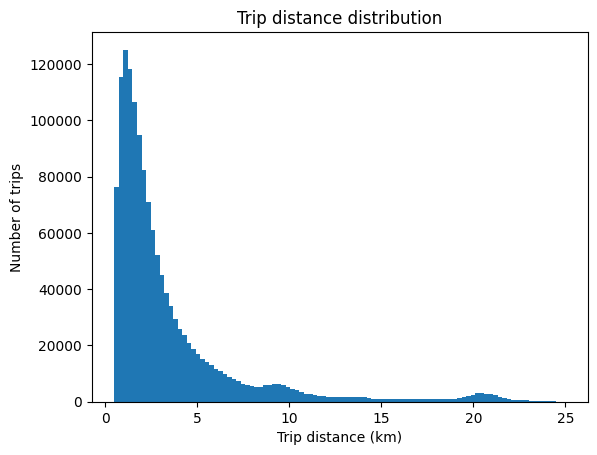

In [77]:
# Plot the new trip distance
df['trip_distance'].plot(kind='hist', bins=100)
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')
plt.title('Trip distance distribution')
plt.show()

# Average Speed

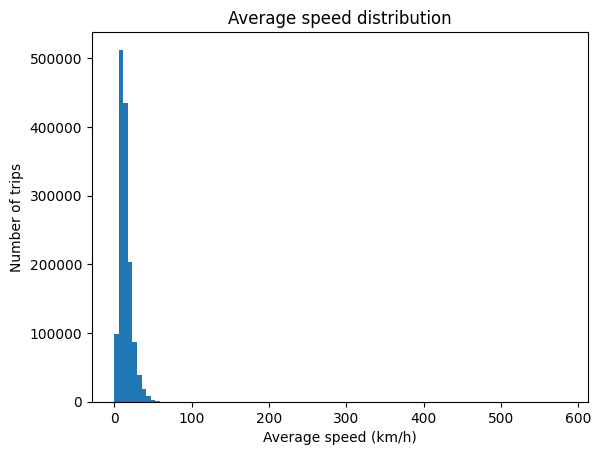

In [78]:
# Plot the average speed, so we can see the distribution, also have a threshold
df['avg_speed'].plot(kind='hist', bins=100)
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()


This histogram represents the average speed distribution for taxi trips. Most trips have an average speed between 5 and 20 km/h, with a peak around 10 km/h, indicating the typical speed of taxi trips within an urban area like New York City. There’s a gradual decline in frequency as speed increases, and a very small number of trips with speeds exceeding 40 km/h, which could potentially be outliers.

Justification for Cleaning Based on Average Speed:
Typical Speeds:

The majority of taxi trips seem to have an average speed between 5 and 20 km/h, which aligns with expected urban driving conditions (due to traffic, signals, and frequent stops).
Trips with speeds under 1 km/h are highly improbable and might indicate errors in data capture or extremely short trips that skew the results.
Speeds exceeding 50 km/h seem to be extremely rare in this dataset, which suggests that such high-speed trips are potential outliers or represent trips that took place on highways.
Filtering Extremes:

Given the distribution, a reasonable upper threshold for speed could be 50 km/h to remove outliers that are far from typical urban driving speeds.
A lower threshold of 1 km/h helps to exclude trips where the speed is unrealistic for a typical trip (likely data capture issues).

In [79]:
# Average speed threshold
df = df[(df['avg_speed'] < 60) & (df['avg_speed'] > 3)]

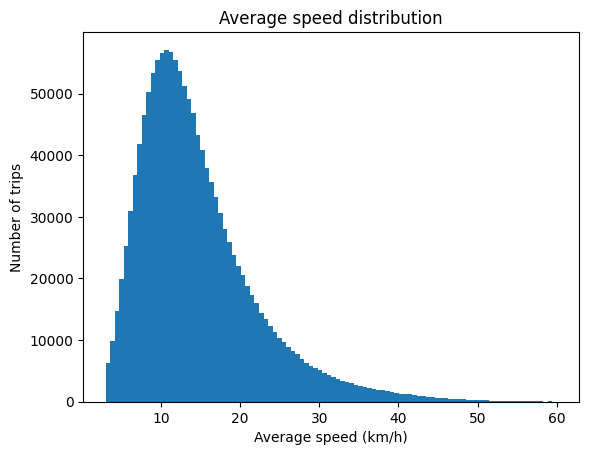

In [80]:
# Plot the new average speed
df['avg_speed'].plot(kind='hist', bins=100)
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()

# Updated Scatter Plot

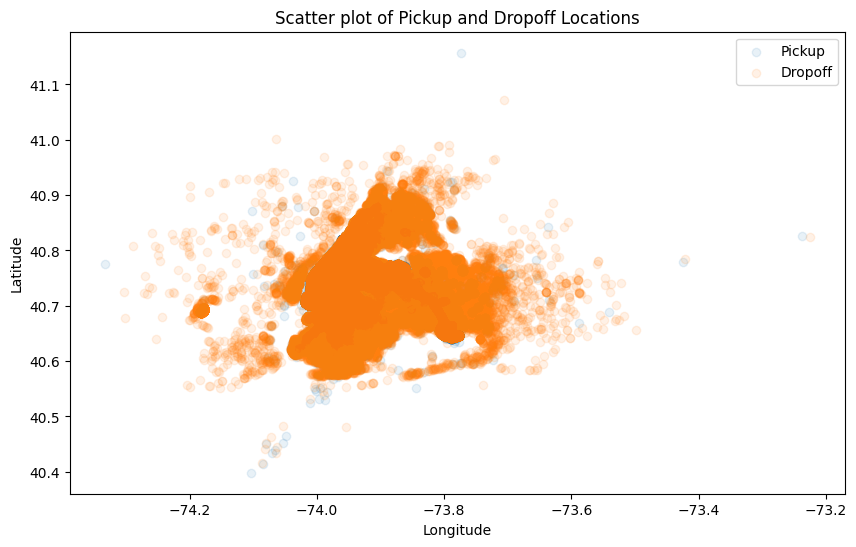

In [81]:
# Scatter plot of pickup and dropoff locations
plt.figure(figsize=(10, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.1, label='Pickup')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], alpha=0.1, label='Dropoff')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of Pickup and Dropoff Locations')
plt.legend()
plt.show()

# Feature: Extract Day of the Week from Pickup Datetime

In [82]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()

# Feature: Hour of Day

In [83]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Visualize and Clean Passenger Count

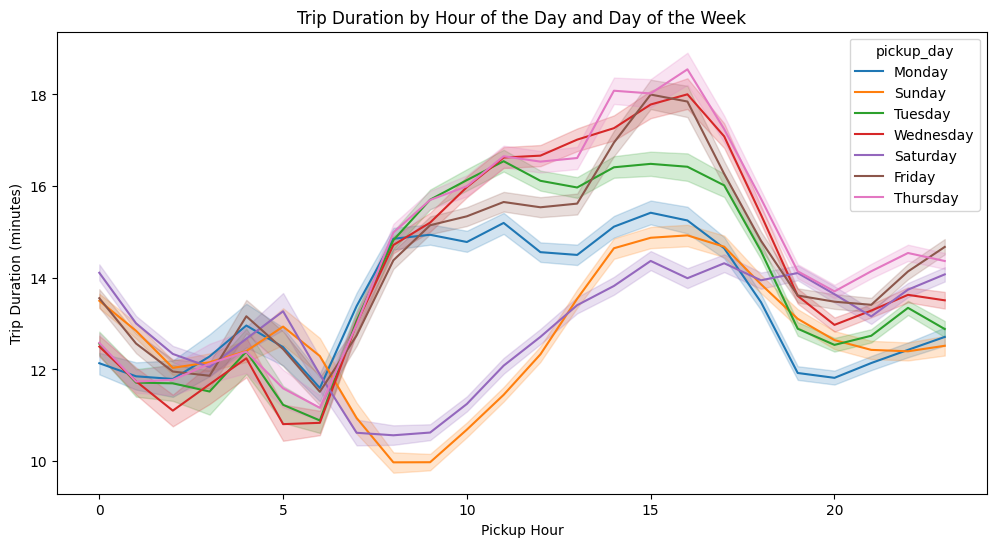

In [84]:
# Plot trip duration by day of the week and pickup time
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='pickup_day', data=df)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Day of the Week')
plt.show()

In [85]:
df['passenger_count'] = pd.Categorical(df['passenger_count'])

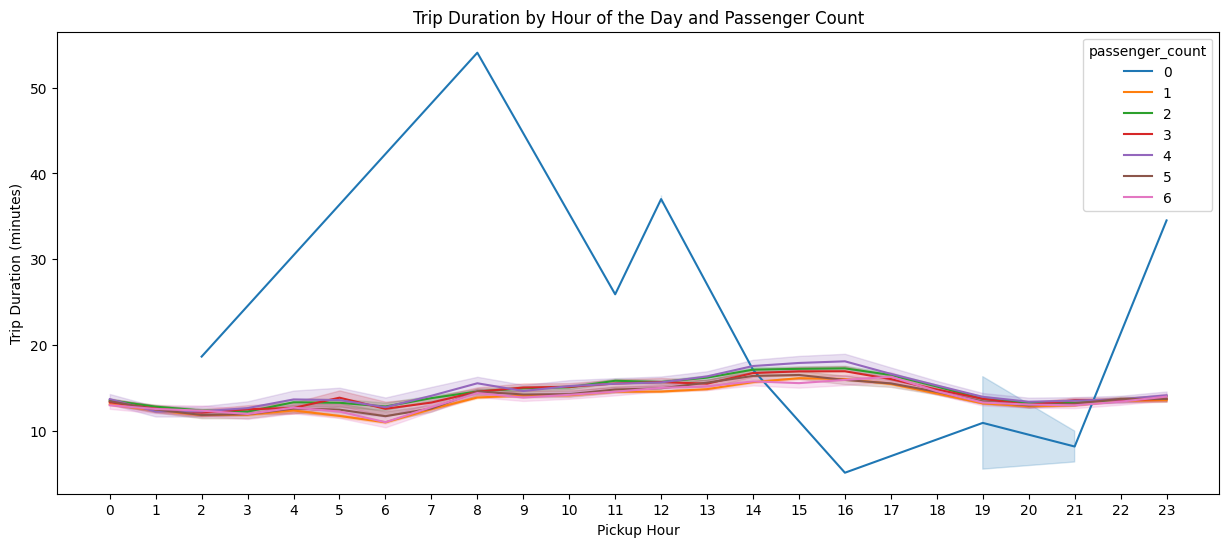

In [86]:
# Plot trip duration by passenger count and pickup time
plt.figure(figsize=(15, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='passenger_count', data=df)
hourly_ticks = range(0,24)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Passenger Count')
plt.xticks(hourly_ticks)
plt.show()

In [87]:
# Remove the peak when passenger count is 0 and greater than the trip duration of 20 minutes
df = df[(df['passenger_count'] != 0) | (df['trip_duration'] < 17)]

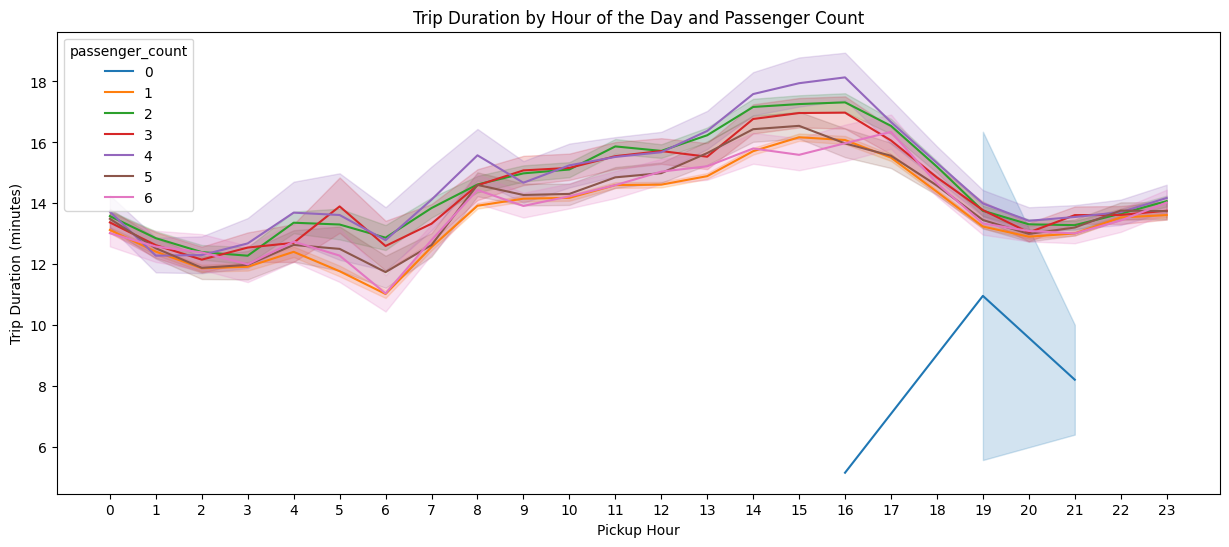

In [88]:
# Plot the cleaned data
plt.figure(figsize=(15, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='passenger_count', data=df)
hourly_ticks = range(0,24)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Passenger Count')
plt.xticks(hourly_ticks)
plt.show()

# Inspect data

In [89]:
print(df.head())

          id  vendor_id     pickup_datetime    dropoff_datetime   
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30  \
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude   
0               1        -73.982155        40.767937         -73.964630  \
1               1        -73.980415        40.738564         -73.999481   
2               1        -73.979027        40.763939         -74.005333   
3               1        -74.010040        40.719971         -74.012268   
4               1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  trip_distance   
0         40.765602                  N       7.583333       1.497580  \
1 

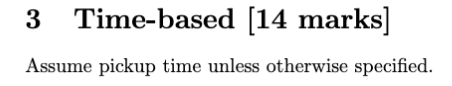

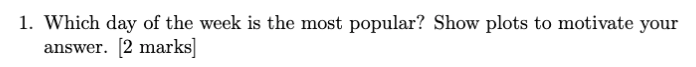

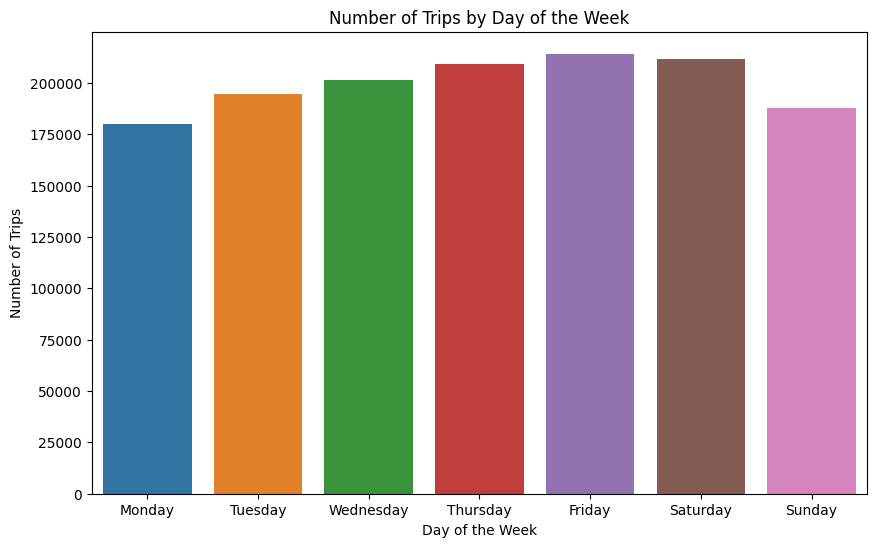

In [90]:
# Daggy and Muz Job
# Sayf is a flop    :D

# Which day of the week is the most popular? Show plots to motivate your answer.

# Count the number of trips for each day of the week
day_counts = df['pickup_day'].value_counts()

# Plot the number of trips for each day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of the Week')
plt.show()



Friday :)

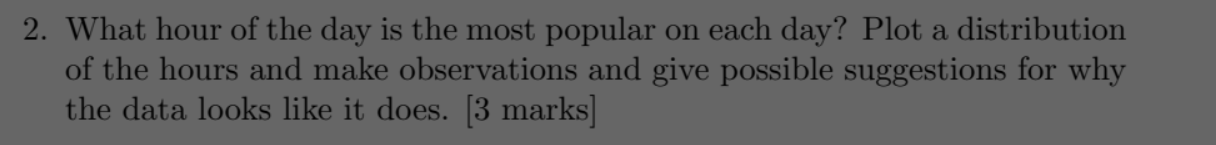

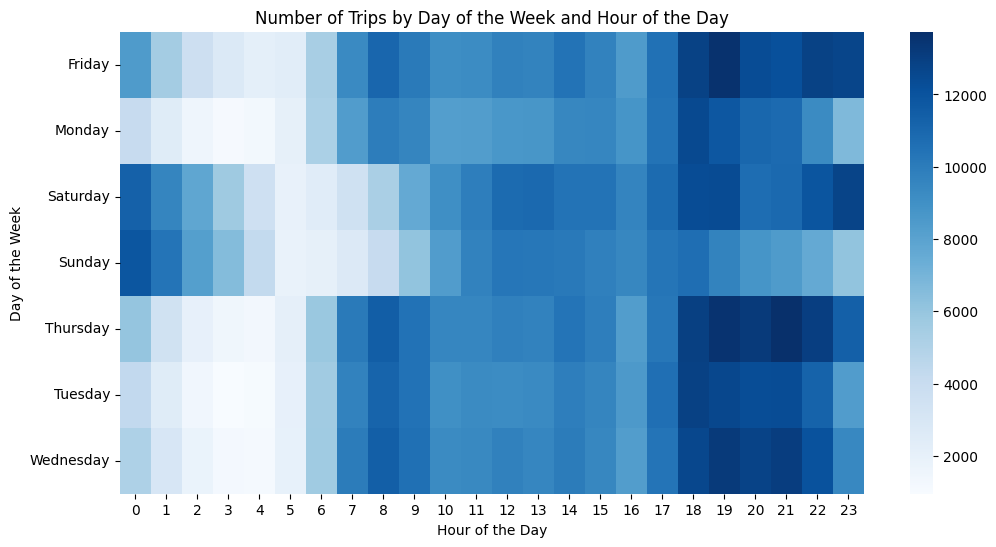

In [91]:
# What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

# Count the number of trips for each day of the week and hour of the day
day_hour_counts = df.groupby(['pickup_day', 'pickup_hour']).size().unstack()

# Plot the number of trips for each day of the week and hour of the day
plt.figure(figsize=(12, 6))
sns.heatmap(day_hour_counts, cmap='Blues')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Number of Trips by Day of the Week and Hour of the Day')
plt.show()


Monday - 6pm
Tuesday - 6pm
Wednesday - 7pm
Thursday - 7pm / 9pm
Friday - 7pm
Saturday - 11pm
Sunday - 12 am


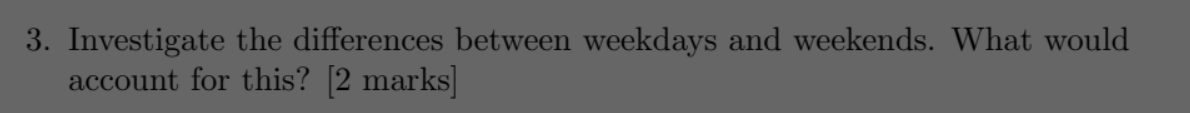

Monday to Friday is during when work ends
Saturday and Sunday is during the late hrs, late night partying

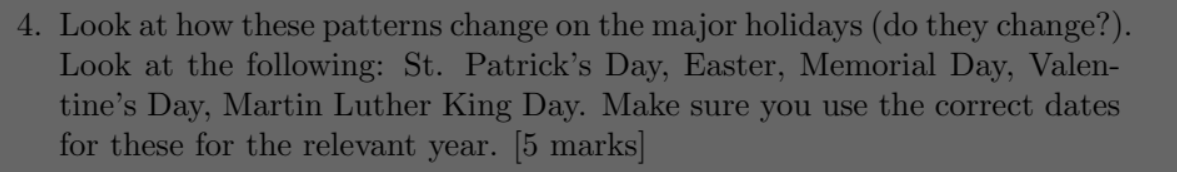

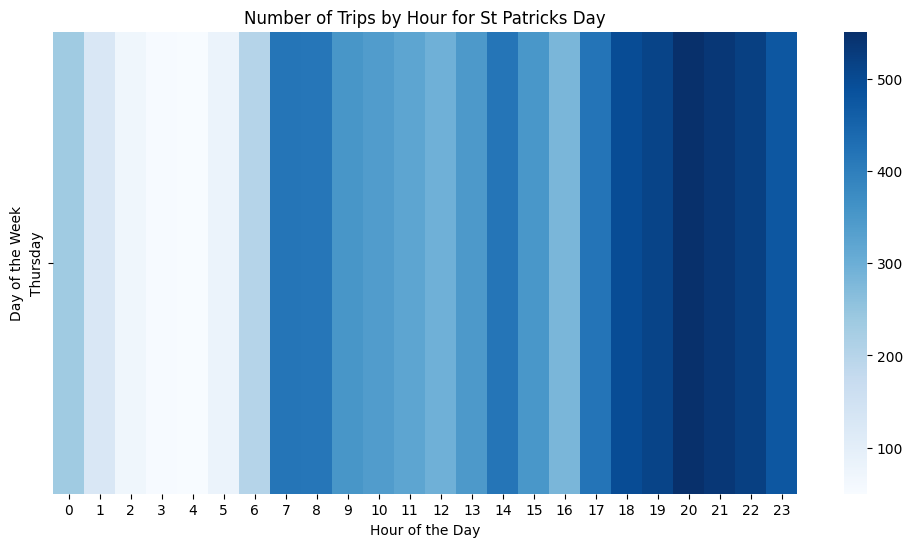

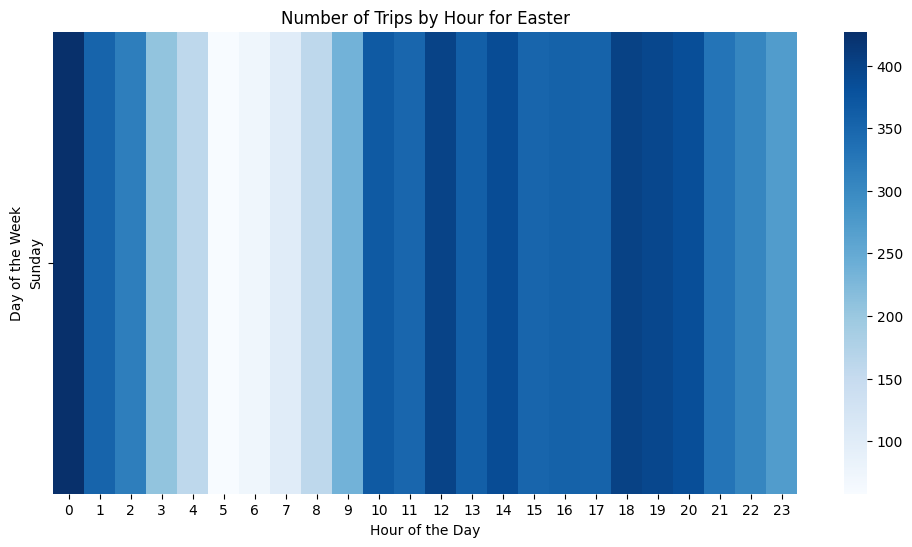

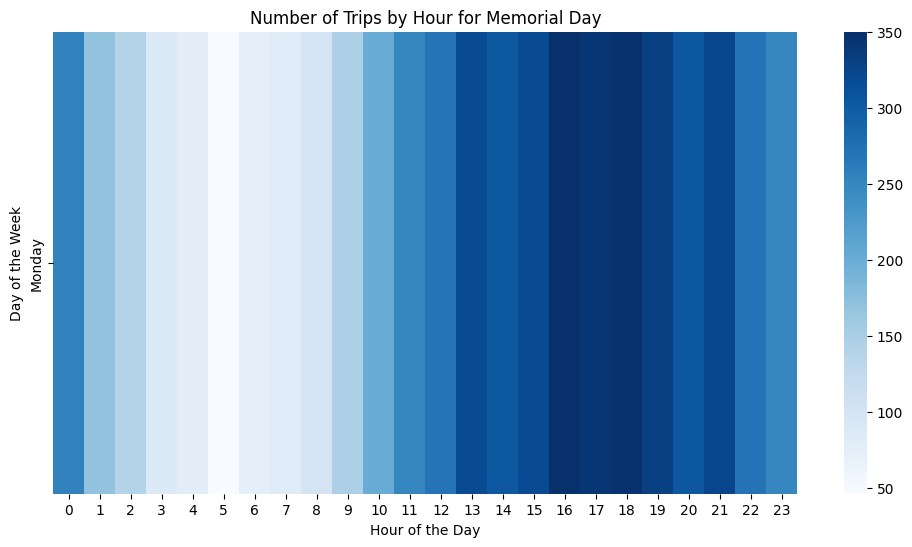

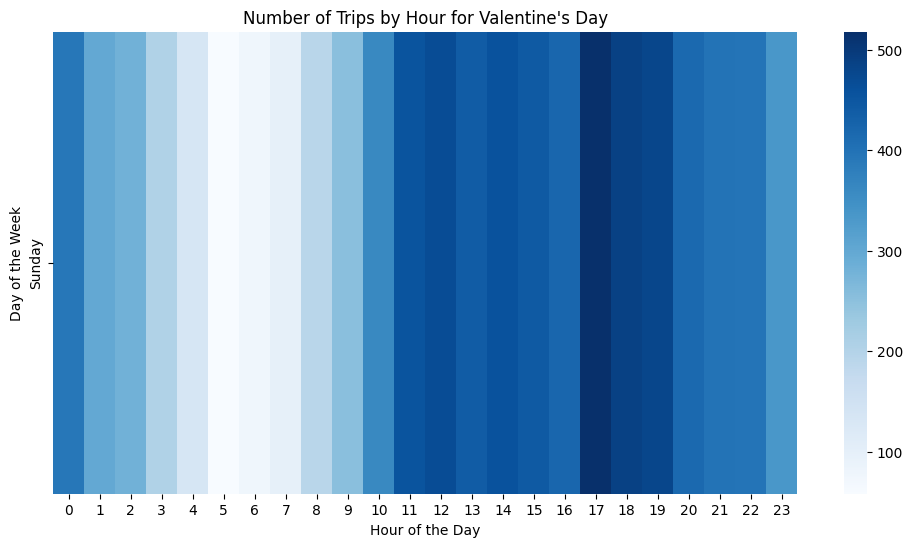

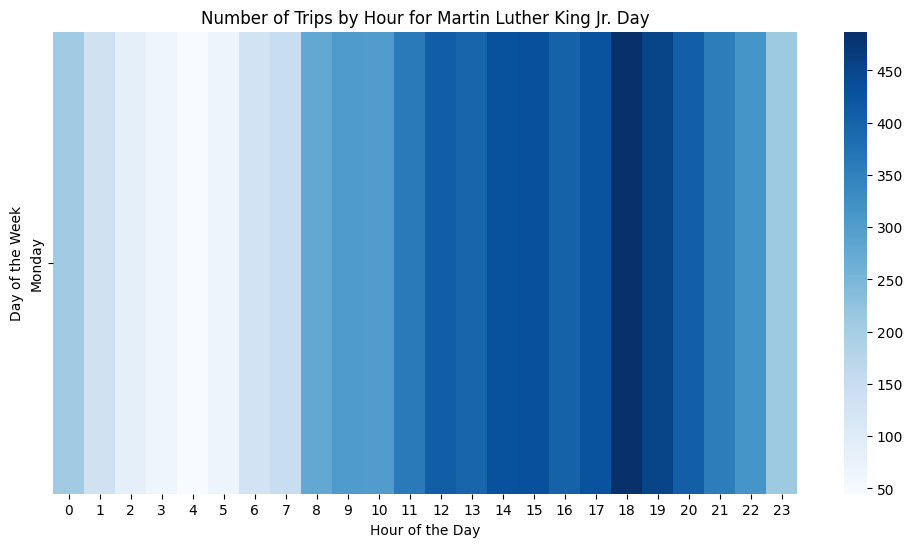

In [92]:
# St Patricks Day: 17th March
# Easter: 27th March
# Memorial Day: 30th May
# Valentine's Day: 14th February
# Martin Luther King Jr. Day: 18th January

# Define holidays for the year 2016
holidays = {
    'St Patricks Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    "Valentine's Day": '2016-02-14',
    'Martin Luther King Jr. Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holidays_dt = {holiday: pd.to_datetime(date) for holiday, date in holidays.items()}

# Create a new column for the day of the week and hour of the day
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour_of_day'] = df['pickup_datetime'].dt.hour

# Filter data for holidays
holiday_data = pd.DataFrame()

for holiday, date in holidays_dt.items():
    # Use .loc to avoid SettingWithCopyWarning
    filtered = df.loc[df['pickup_datetime'].dt.date == date.date()].copy()  # Make an explicit copy
    filtered['holiday'] = holiday
    holiday_data = pd.concat([holiday_data, filtered])

# Group data by holiday, day of the week, and hour of the day
day_hour_counts = holiday_data.groupby(['holiday', 'day_of_week', 'hour_of_day']).size().unstack()

# Plotting
for holiday in holidays.keys():
    plt.figure(figsize=(12, 6))
    sns.heatmap(day_hour_counts.loc[holiday], cmap='Blues')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Week')
    plt.title(f'Number of Trips by Hour for {holiday}')
    plt.show()

Thursday - 8pm (St Patricks) (No change)
Sunday - 12am (Easter) (No change)
Monday - 4pm (Memorial) (Change)
Sunday - 5pm (Valentines) (Change)
Monday - 6pm (Martin) (No change)




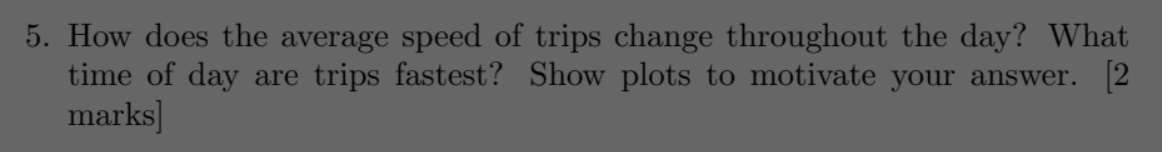

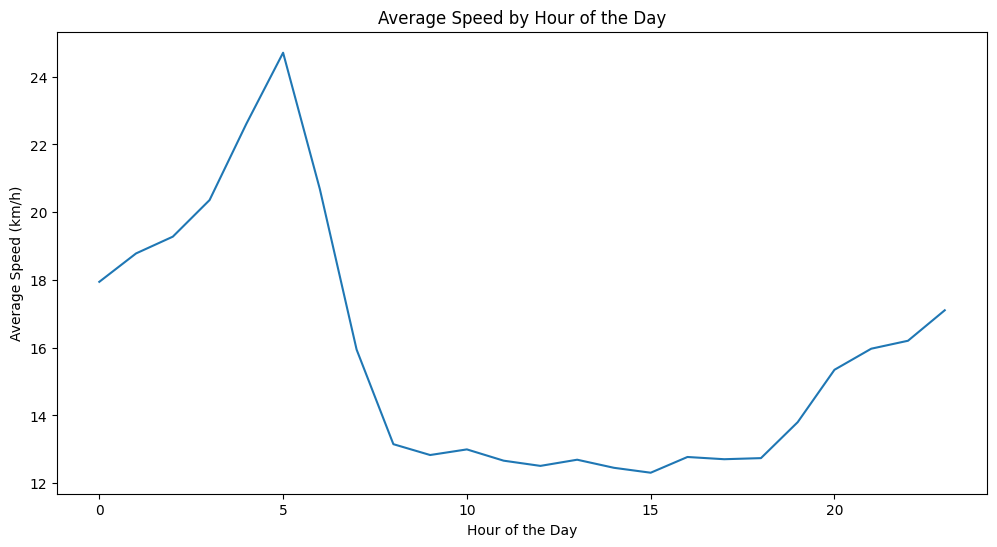

In [93]:
# How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

# Calculate the average speed for each hour of the day
avg_speed_by_hour = df.groupby('pickup_hour')['avg_speed'].mean()

# Plot the average speed for each hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_by_hour.index, y=avg_speed_by_hour.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed by Hour of the Day')
plt.show()


Why the speed so low?
During the early parts of the morning, and late parts of the night, there is little traffic, hence the speed is greater than during the day where there would be more traffic